# satCORPS composite Sketch #2 Subsetting

- Uses starepandas branch granular_democracy


In [28]:
import pystare
import starepandas
import geopandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import datetime

In [29]:
import dask

In [30]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)
        self.data['map_data/BT_12.0m'] = self.source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

            
starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

In [31]:
start0 = datetime.datetime.now()

In [32]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name, sidecar=True, latlon=False, sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')

saving:  map_data/BT_12.0m
saving:  lats
saving:  lons


In [33]:
composite

,sids,map_data/BT_12.0m,lats,lons
0,4017204261523273368,NaN,89.986488,-179.986481
1,4017204261523247416,NaN,89.986488,-179.959457
2,4017204261523249592,NaN,89.986488,-179.932434
3,4017204261522814744,NaN,89.986488,-179.905411
4,4017204261522830296,NaN,89.986488,-179.878372
...,...,...,...,...
88711195,2287821927561911288,NaN,-89.986488,179.878372
88711196,2287821927561922552,NaN,-89.986488,179.905411
88711197,2287821927561869976,NaN,-89.986488,179.932434
88711198,2287821927561869144,NaN,-89.986488,179.959457


In [34]:
# composite.dropna(subset=['map_data/BT_12.0m'],inplace=True)

In [35]:
numpy.amin(composite['map_data/BT_12.0m']),numpy.amax(composite['map_data/BT_12.0m'])

(183.61000061035156, 328.8999938964844)

In [36]:
composite

,sids,map_data/BT_12.0m,lats,lons
0,4017204261523273368,NaN,89.986488,-179.986481
1,4017204261523247416,NaN,89.986488,-179.959457
2,4017204261523249592,NaN,89.986488,-179.932434
3,4017204261522814744,NaN,89.986488,-179.905411
4,4017204261522830296,NaN,89.986488,-179.878372
...,...,...,...,...
88711195,2287821927561911288,NaN,-89.986488,179.878372
88711196,2287821927561922552,NaN,-89.986488,179.905411
88711197,2287821927561869976,NaN,-89.986488,179.932434
88711198,2287821927561869144,NaN,-89.986488,179.959457


In [37]:
# Get some locales
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.sort_values(by='name', inplace=True)
world = starepandas.STAREDataFrame(world)

<AxesSubplot:>

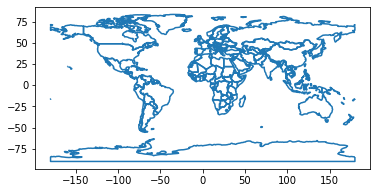

In [38]:
world.plot(trixels=False)

/Users/mrilee/opt/anaconda3/envs/pystare-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/mrilee/opt/anaconda3/envs/pystare-dev/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


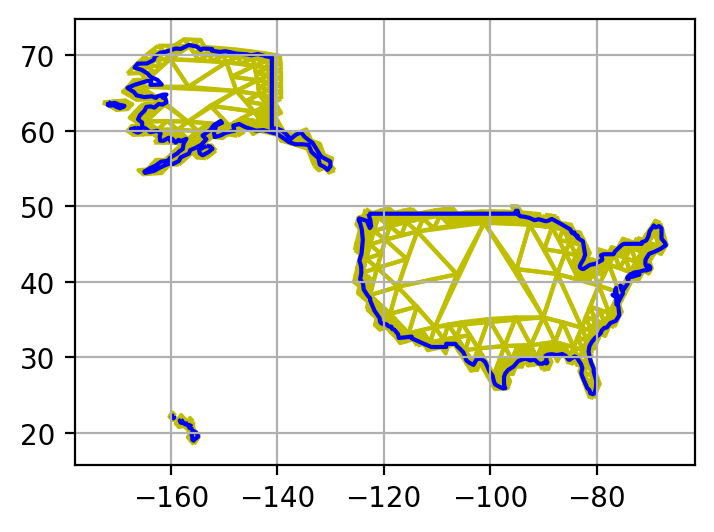

In [39]:
#
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.grid(True)

country = world[world.name=='United States of America']
# country = world[world.name=='Bahamas']
# country = world[world.name=='Vanuatu']
# country = world[world.name=='Iceland']
country.set_sids(country.make_sids(resolution=7),inplace=True)
country.set_trixels(country.make_trixels(),inplace=True)
country.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
country.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
# modis.plot(ax=ax, color='red', trixels=False, zorder=0)

del fig,ax

In [40]:
a = composite.stare_intersects(country['sids'].iloc[0],n_workers=50)

In [41]:
a

0           False
1           False
2           False
3           False
4           False
            ...  
88711195    False
88711196    False
88711197    False
88711198    False
88711199    False
Length: 88711200, dtype: bool

In [42]:
composite_subset = composite[a]

In [43]:
composite_subset

,sids,map_data/BT_12.0m,lats,lons
8818672,3988403672722849933,NaN,72.094597,-157.500000
8818673,3988403689918098925,NaN,72.094597,-157.472977
8818674,3988403686891614605,NaN,72.094597,-157.445938
8818675,3988025446782427021,NaN,72.094597,-157.418915
8818676,3988025557259106221,NaN,72.094597,-157.391891
...,...,...,...,...
35232301,1171604754501895308,293.259979,18.500000,-155.635132
35232302,1171604589599290348,293.229980,18.500000,-155.608109
35232303,1171604568229541548,293.220001,18.500000,-155.581085
35245621,1171604495618840492,292.750000,18.472973,-155.635132


In [44]:
# Maybe I don't need to do this.
# joined = starepandas.stare_join(composite, country, how='left')

In [45]:
# joined_trimmed = joined.dropna()

In [46]:
# jdf = starepandas.STAREDataFrame(joined_trimmed)

In [47]:
# type(jdf)

In [48]:
# jdf1=jdf[0:100]
# jdf1=jdf
jdf1=composite_subset

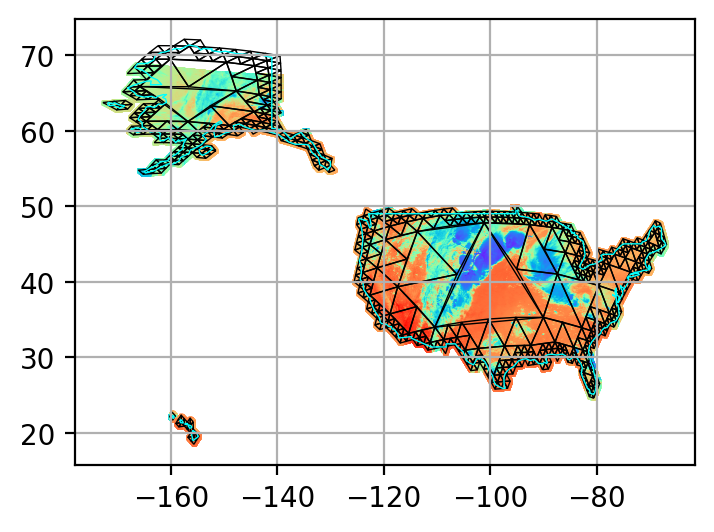

In [49]:
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.grid(True)
if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    marker_size=0.5
    marker_alpha=0.75
    
marker='s'

# jdf1.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# jdf1.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

plt.scatter(jdf1['lons'],jdf1['lats']
            ,s=marker_size
            ,c=jdf1['map_data/BT_12.0m']
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow'
            ,marker=marker
            )
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

country.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
country.plot(ax=ax, trixels=False, facecolor="none", edgecolor='cyan', zorder=1, linewidth=0.5)
    
del fig,ax

In [50]:
print(datetime.datetime.now() - start0)

0:01:44.044215


## Debugging

In [51]:
# source_nc = starepandas.io.s3.nc4_dataset_wrapper(granule_name, 'r', format='NETCDF4')

In [52]:
# data={}

In [53]:
# data['map_data/BT_12.0m'] = source_nc.groups['map_data']['BT_12.0um'][:].astype(numpy.double)

In [54]:
# source_nc.groups['map_data']['BT_12.0um'][1000][1000]